<a href="https://colab.research.google.com/github/ashishangra17/Anomaly_Detection/blob/main/Lead_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [697]:
import warnings
warnings.filterwarnings('ignore')

In [698]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score


import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE

In [699]:
!pip install xgboost

### Reading Leads data file

In [700]:
#from google.colab import files
#files.upload()
leads_df = pd.read_csv('train_s3TEQDk.csv')
leads_df.index = leads_df["ID"]
leads_df.head()
#files.upload()
leads_df_test = pd.read_csv('test_mSzZ8RL.csv')
leads_df_test.index = leads_df_test["ID"]
leads_df_test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
ID,,,,,,,,,,
VBENBARO,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
CCMEWNKY,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
VK3KGA9M,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
TT8RPZVC,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
SHQZEYTZ,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


#### Inspect dataframe 

In [701]:
print(leads_df.columns)
print("") # empty line for formatting

print("Shape: " + str(leads_df.shape))
print("") # empty line for formatting

print("dtypes: " + str(leads_df.dtypes))
print("") # empty line for formatting

print("describe: " + str(leads_df.describe()))     
print("") # empty line for formatting
      
print(leads_df.info)
print("") # empty line for formatting

print("Size of frame: " + str(leads_df.size))

#printing few rows
leads_df.head()


Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead'],
      dtype='object')

Shape: (245725, 11)

dtypes: ID                     object
Gender                 object
Age                     int64
Region_Code            object
Occupation             object
Channel_Code           object
Vintage                 int64
Credit_Product         object
Avg_Account_Balance     int64
Is_Active              object
Is_Lead                 int64
dtype: object

describe:                  Age        Vintage  Avg_Account_Balance        Is_Lead
count  245725.000000  245725.000000         2.457250e+05  245725.000000
mean       43.856307      46.959141         1.128403e+06       0.237208
std        14.828672      32.353136         8.529364e+05       0.425372
min        23.000000       7.000000         2.079000e+04       0.000000
25%        30.000000      20.000000         6.043100e+05       0.00

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
ID,,,,,,,,,,,
NNVBBKZB,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
IDD62UNG,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
HD3DSEMC,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
BF3NC7KV,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
TEASRWXV,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


### Converting Select Value to Nan values

In [702]:
# As select means that the values have not been selected by the user, Converting them to NAn will help to analyse it correctly.
leads_df = leads_df.replace('Select', np.nan)

### Inspect Null values for cleaning the dataframe        

In [703]:
# Check column-wise null count
leads_df.isnull().sum(axis = 0)

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [704]:
### Only Credit_Product has NULL values. Checking distinct values for same.

In [705]:
leads_df['Credit_Product'].unique()

array(['No', nan, 'Yes'], dtype=object)

In [706]:
# Check the precentage of missing values present - column-wise null percentages
print(round(100*(leads_df.isnull().sum()/len(leads_df.index)),2)) # round for 2 decimal places

ID                      0.00
Gender                  0.00
Age                     0.00
Region_Code             0.00
Occupation              0.00
Channel_Code            0.00
Vintage                 0.00
Credit_Product         11.93
Avg_Account_Balance     0.00
Is_Active               0.00
Is_Lead                 0.00
dtype: float64


In [707]:
## Inspecting the data where Credit_Product has blank values.

In [708]:
leads_df[leads_df['Credit_Product'].isna()]

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
ID,,,,,,,,,,,
ETQCZFEJ,ETQCZFEJ,Male,62,RG282,Other,X3,20,NaN,1056750,Yes,1
UJ2NJKKL,UJ2NJKKL,Male,33,RG268,Self_Employed,X2,69,NaN,517063,Yes,1
ABPMK4WU,ABPMK4WU,Female,32,RG279,Salaried,X4,15,NaN,1072850,Yes,1
MTEIXMB9,MTEIXMB9,Female,41,RG268,Self_Employed,X3,62,NaN,962383,No,1
6WX9JDVK,6WX9JDVK,Female,63,RG254,Other,X3,103,NaN,1249319,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...
WVJFPREY,WVJFPREY,Female,51,RG281,Entrepreneur,X3,99,NaN,552992,No,1
WIZBXYQZ,WIZBXYQZ,Female,50,RG277,Self_Employed,X2,92,NaN,1385124,No,1
MARTXU7T,MARTXU7T,Male,53,RG254,Other,X2,19,NaN,1141825,Yes,1


In [709]:
## Replacing all NaN with NO for Credit_Product Column.

In [710]:
leads_df['Credit_Product'] = leads_df['Credit_Product'].replace(np.nan,'No')

## Apply to test as well
leads_df_test['Credit_Product'] = leads_df_test['Credit_Product'].replace(np.nan,'No')


In [711]:
# Checking Credit Product Column values and %ge distribution
(leads_df.Credit_Product.value_counts()/leads_df.Credit_Product.count())*100

No     70.681453
Yes    29.318547
Name: Credit_Product, dtype: float64

In [712]:
leads_df.count()

ID                     245725
Gender                 245725
Age                    245725
Region_Code            245725
Occupation             245725
Channel_Code           245725
Vintage                245725
Credit_Product         245725
Avg_Account_Balance    245725
Is_Active              245725
Is_Lead                245725
dtype: int64

In [713]:
## EDA on each column one by one - Univariate Analaysis

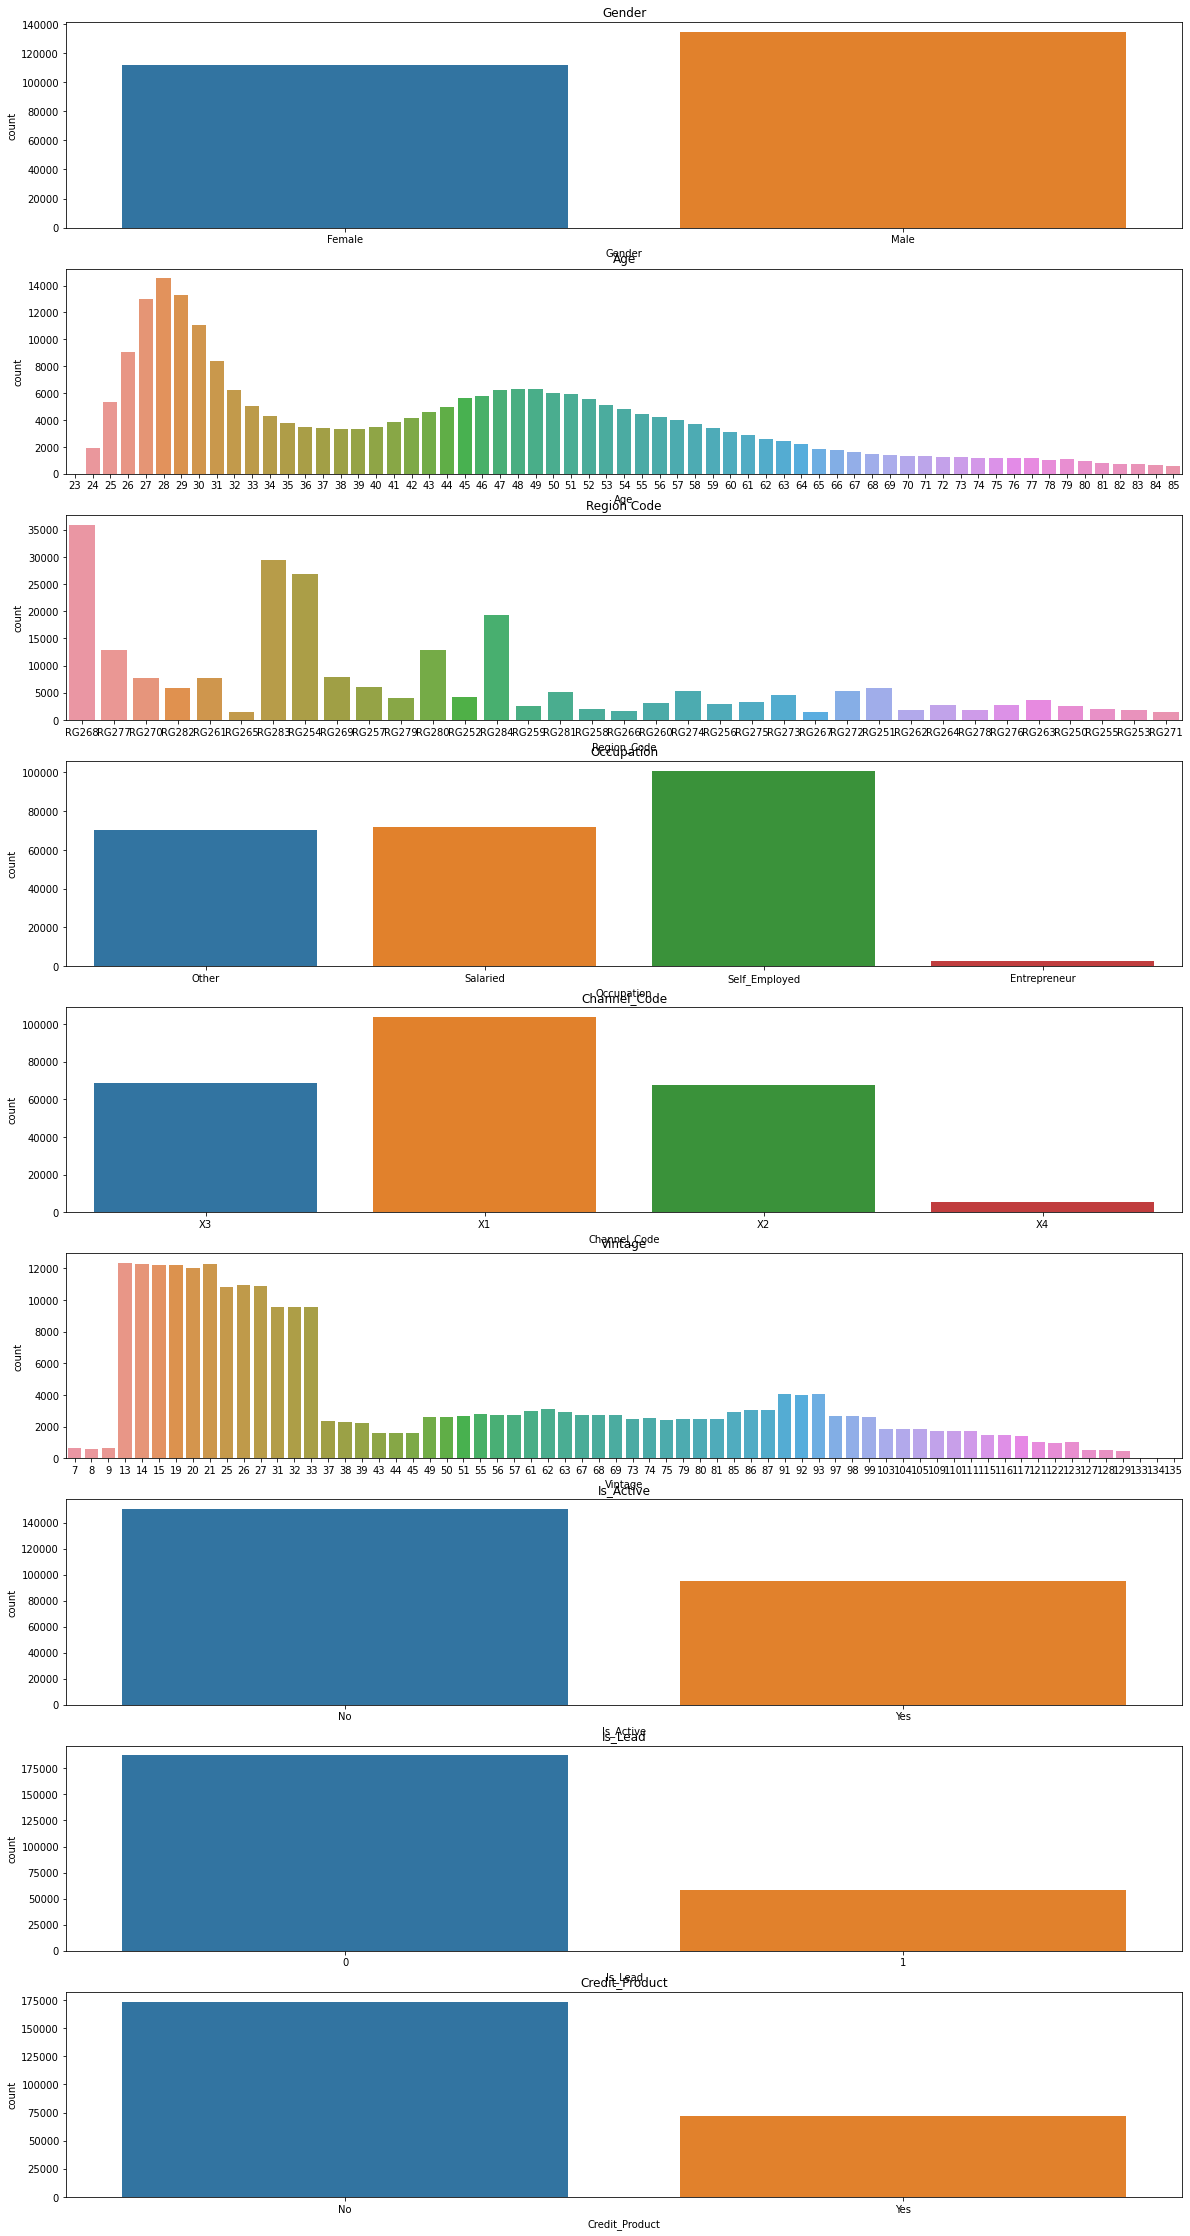

In [714]:
plt.figure(figsize = (20,40))

plt.subplot(9,1,1)
sns.countplot(leads_df['Gender'])
plt.title('Gender')

plt.subplot(9,1,2)
sns.countplot(leads_df['Age'])
plt.title('Age')

plt.subplot(9,1,3)
sns.countplot(leads_df['Region_Code'])
plt.title('Region Code')

plt.subplot(9,1,4)
sns.countplot(leads_df['Occupation'])
plt.title('Occupation')

plt.subplot(9,1,5)
sns.countplot(leads_df['Channel_Code'])
plt.title('Channel_Code')

plt.subplot(9,1,6)
sns.countplot(leads_df['Vintage'])
plt.title('Vintage')


plt.subplot(9,1,7)
sns.countplot(leads_df['Is_Active'])
plt.title('Is_Active')

plt.subplot(9,1,8)
sns.countplot(leads_df['Is_Lead'])
plt.title('Is_Lead')

plt.subplot(9,1,9)
sns.countplot(leads_df['Credit_Product'])
plt.title('Credit_Product')



plt.show()

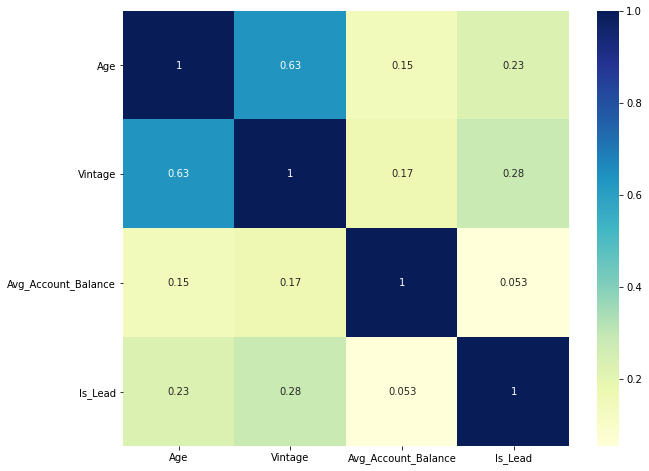

In [715]:
#Checking correlations of numeric values
plt.figure(figsize=(10,8))

# heatmap
sns.heatmap(leads_df.corr(), cmap="YlGnBu", annot=True)
plt.show()

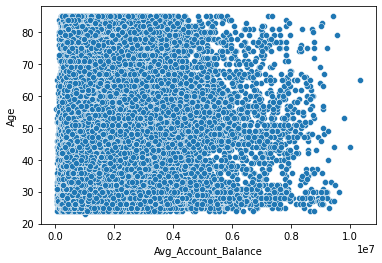

In [716]:
sns.scatterplot(x= "Avg_Account_Balance", y = "Age", data = leads_df )

In [717]:
# Get the categorical columns from the columns list- using object type
categorical_cols= leads_df.select_dtypes(include=['object']).columns
categorical_cols

Index(['ID', 'Gender', 'Region_Code', 'Occupation', 'Channel_Code',
       'Credit_Product', 'Is_Active'],
      dtype='object')

In [718]:
#### Converting some binary variables (Yes/No) to 0/1

In [719]:
# List of variables to map

varlist =  ['Is_Active', 'Credit_Product']

# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function to the housing list
leads_df[varlist] = leads_df[varlist].apply(binary_map)


In [720]:
leads_df_test[varlist] = leads_df_test[varlist].apply(binary_map)

In [721]:
### Converting Numerical Columns to Categorical Columns

In [722]:
def age_cat(x):
    if 0 < x <= 18:
        return 'CA1'
    elif 18 < x <= 30:
        return 'CA2'
    elif 30 < x <= 45:
        return 'CA3'
    elif 45 < x <= 60:
        return 'CA4'
    elif 60 < x <= 80:
        return 'CA5'
    return 'CA6'

leads_df["Age_Category"]= leads_df["Age"].apply(age_cat)



In [723]:
leads_df_test["Age_Category"]= leads_df_test["Age"].apply(age_cat)

In [724]:
def vintage_cat(x):
    if 0 < x <= 18:
        return 'CV1'
    elif 18 < x <= 30:
        return 'CV2'
    elif 30 < x <= 45:
        return 'CV3'
    elif 45 < x <= 60:
        return 'CV4'
    elif 60 < x <= 80:
        return 'CV5'
    elif 80 < x <= 100:
        return 'CV6'
    return 'CV7'

leads_df["Vintage_Category"]= leads_df["Vintage"].apply(vintage_cat)
leads_df_test["Vintage_Category"]= leads_df_test["Vintage"].apply(vintage_cat)


In [725]:
def avg_act_bal_cat(x):
    if 0 < x <= 10000:
        return 'CAB1'
    elif 10000 < x <= 100000:
        return 'CAB2'
    elif 100000 < x <= 400000:
        return 'CAB3'
    elif 400000 < x <= 700000:
        return 'CAB4'
    elif 700000 < x <= 1000000:
        return 'CAB5'
    elif 1000000 < x <= 1500000:
        return 'CAB6'
    elif 1500000 < x <= 2500000:
        return 'CAB7'
    elif 2500000 < x <= 4000000:
        return 'CAB8'
    elif 4000000 < x <= 6000000:
        return 'CAB9'
    return 'CAB10'

leads_df["Avg_AcBal_Category"]= leads_df["Avg_Account_Balance"].apply(avg_act_bal_cat)
leads_df_test["Avg_AcBal_Category"]= leads_df_test["Avg_Account_Balance"].apply(avg_act_bal_cat)


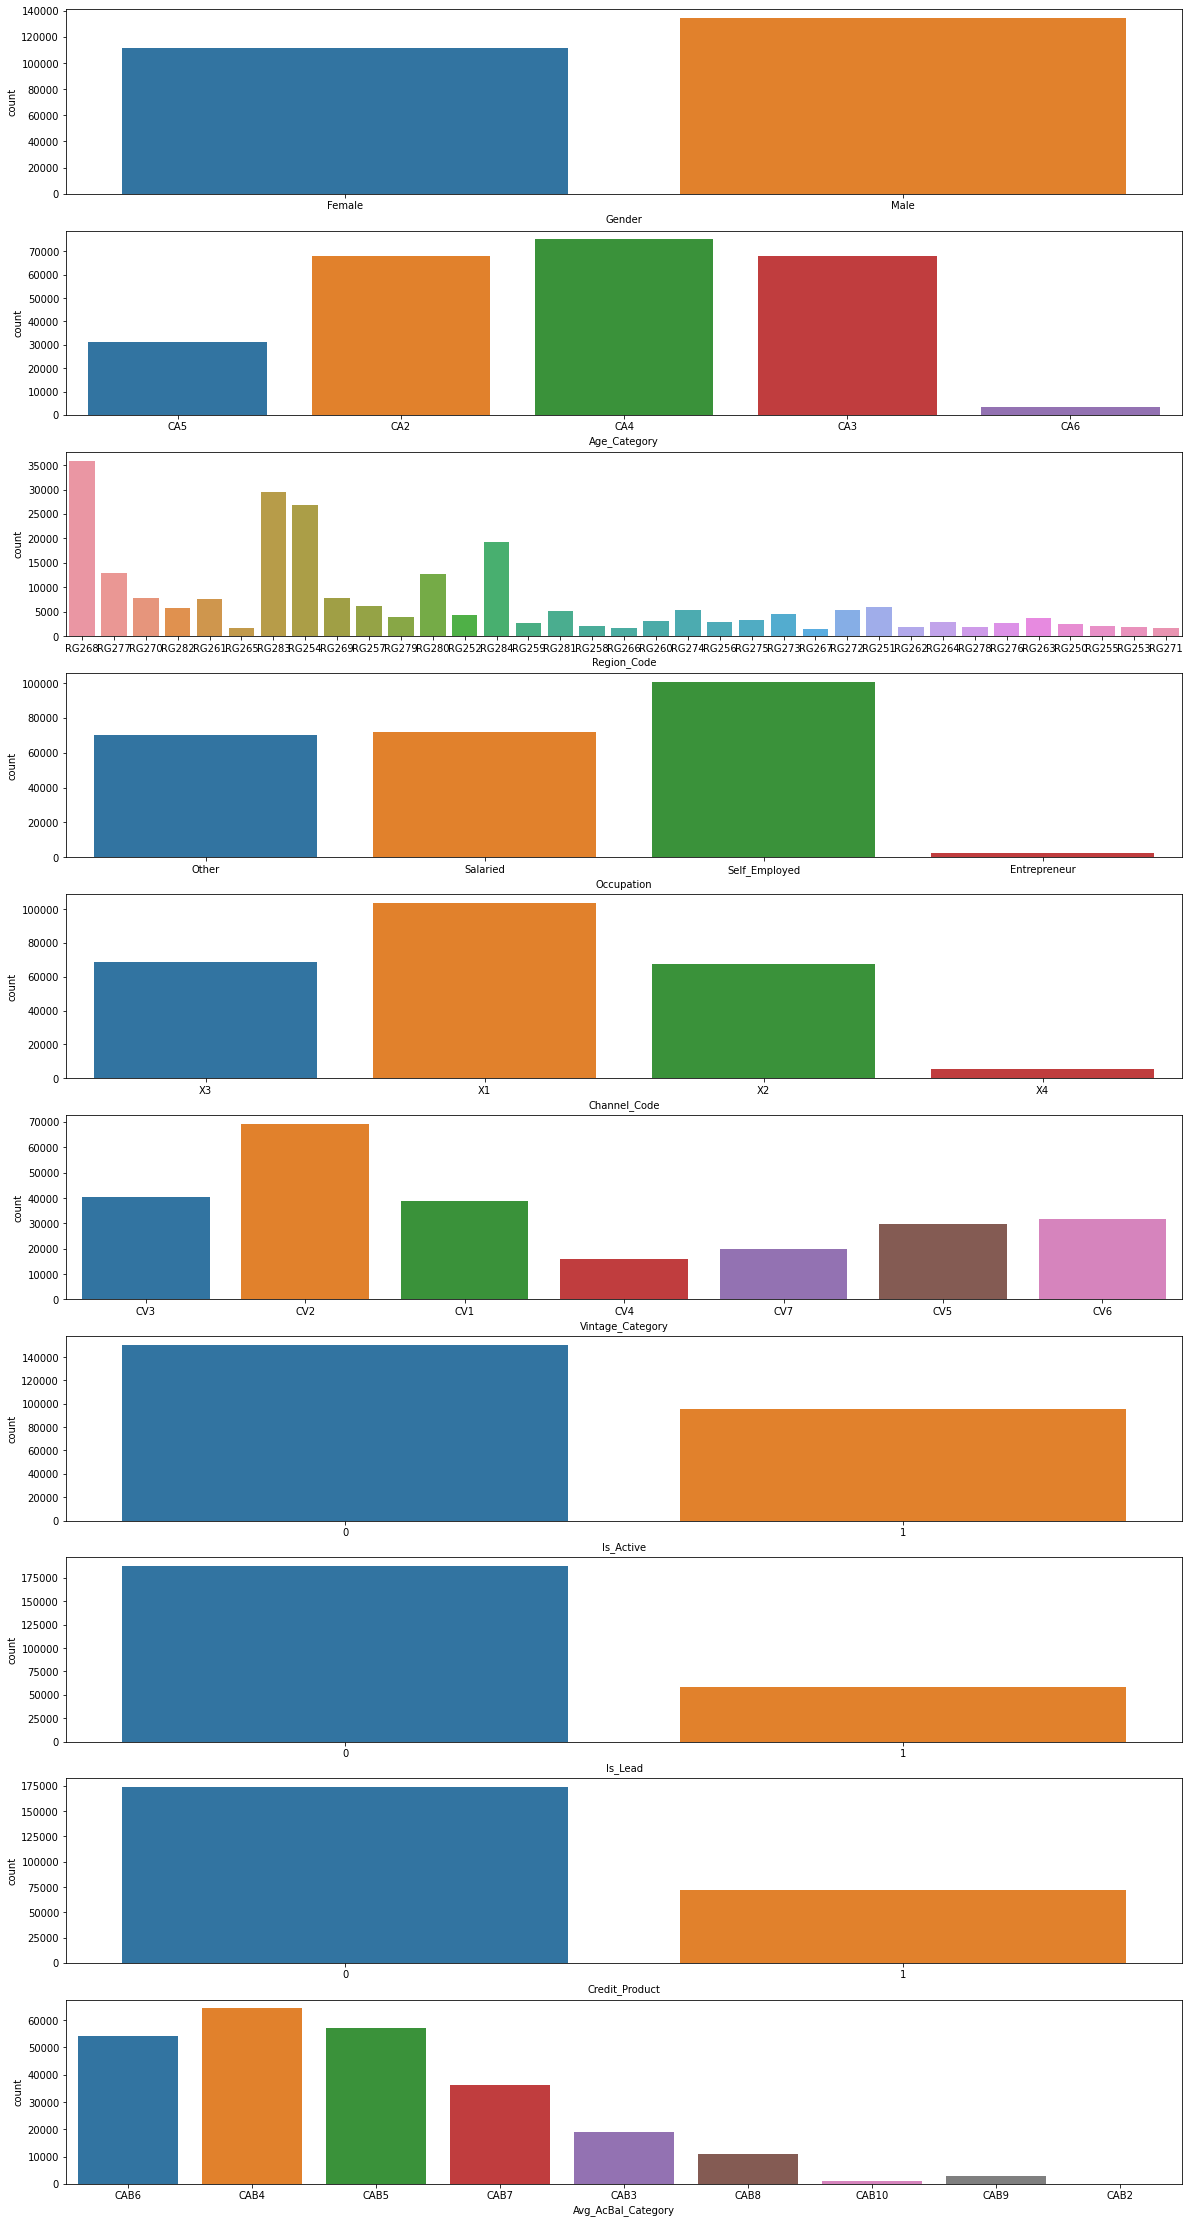

In [726]:
plt.figure(figsize = (20,40))

plt.subplot(10,1,1)
sns.countplot(leads_df['Gender'])
#plt.title('Gender')

plt.subplot(10,1,2)
sns.countplot(leads_df['Age_Category'])
#plt.title('Age')

plt.subplot(10,1,3)
sns.countplot(leads_df['Region_Code'])
#plt.title('Region Code')

plt.subplot(10,1,4)
sns.countplot(leads_df['Occupation'])
#plt.title('Occupation')

plt.subplot(10,1,5)
sns.countplot(leads_df['Channel_Code'])
#plt.title('Channel_Code')

plt.subplot(10,1,6)
sns.countplot(leads_df['Vintage_Category'])
#plt.title('Vintage')


plt.subplot(10,1,7)
sns.countplot(leads_df['Is_Active'])
#plt.title('Is_Active')

plt.subplot(10,1,8)
sns.countplot(leads_df['Is_Lead'])
#plt.title('Is_Lead')

plt.subplot(10,1,9)
sns.countplot(leads_df['Credit_Product'])
#plt.title('Credit_Product')

plt.subplot(10,1,10)
sns.countplot(leads_df['Avg_AcBal_Category'])
#plt.title('Credit_Product')

plt.show()

In [727]:
# Create dummy variables using the 'get_dummies' command
dummy = pd.get_dummies(leads_df[['Gender', 'Age_Category', 'Region_Code', 'Occupation',
                              'Channel_Code', 'Vintage_Category',
                              'Avg_AcBal_Category']], drop_first=True)

# Create dummy variables using the 'get_dummies' command
dummy_test = pd.get_dummies(leads_df_test[['Gender', 'Age_Category', 'Region_Code', 'Occupation',
                              'Channel_Code', 'Vintage_Category',
                              'Avg_AcBal_Category']], drop_first=True)

In [728]:
# Add the results to the master dataframe
leads_df = pd.concat([leads_df, dummy], axis=1)
leads_df_test = pd.concat([leads_df_test, dummy_test], axis=1)

In [729]:
 ## Train-Test Split & Logistic Regression Model Building:

In [730]:
# Put all the feature variables in X, also drop original variables of already dummified variables.

X = leads_df.drop(['Is_Lead','ID','Age','Vintage','Avg_Account_Balance','Gender', 'Age_Category', 'Region_Code', 'Occupation',
                              'Channel_Code', 'Vintage_Category',
                              'Avg_AcBal_Category'], 1)
X.head()
leads_df_test= leads_df_test.drop(['ID','Age','Vintage','Avg_Account_Balance','Gender', 'Age_Category', 'Region_Code', 'Occupation',
                              'Channel_Code', 'Vintage_Category',
                              'Avg_AcBal_Category'], 1)
leads_df_test.head()


,Credit_Product,Is_Active,Gender_Male,Age_Category_CA3,Age_Category_CA4,Age_Category_CA5,Age_Category_CA6,Region_Code_RG251,Region_Code_RG252,Region_Code_RG253,Region_Code_RG254,Region_Code_RG255,Region_Code_RG256,Region_Code_RG257,Region_Code_RG258,Region_Code_RG259,Region_Code_RG260,Region_Code_RG261,Region_Code_RG262,Region_Code_RG263,Region_Code_RG264,Region_Code_RG265,Region_Code_RG266,Region_Code_RG267,Region_Code_RG268,Region_Code_RG269,Region_Code_RG270,Region_Code_RG271,Region_Code_RG272,Region_Code_RG273,Region_Code_RG274,Region_Code_RG275,Region_Code_RG276,Region_Code_RG277,Region_Code_RG278,Region_Code_RG279,Region_Code_RG280,Region_Code_RG281,Region_Code_RG282,Region_Code_RG283,Region_Code_RG284,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Vintage_Category_CV2,Vintage_Category_CV3,Vintage_Category_CV4,Vintage_Category_CV5,Vintage_Category_CV6,Vintage_Category_CV7,Avg_AcBal_Category_CAB2,Avg_AcBal_Category_CAB3,Avg_AcBal_Category_CAB4,Avg_AcBal_Category_CAB5,Avg_AcBal_Category_CAB6,Avg_AcBal_Category_CAB7,Avg_AcBal_Category_CAB8,Avg_AcBal_Category_CAB9
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
VBENBARO,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
CCMEWNKY,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
VK3KGA9M,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
TT8RPZVC,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
SHQZEYTZ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


In [731]:
# Put the target variable in y
Y = leads_df['Is_Lead']
Y.head()


ID
NNVBBKZB    0
IDD62UNG    0
HD3DSEMC    0
BF3NC7KV    0
TEASRWXV    0
Name: Is_Lead, dtype: int64

In [732]:
# Split the dataset into 70% train and 30% test

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, test_size=0.3, random_state=100)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172007 entries, L29UAVJD to VEZXWTUJ
Data columns (total 61 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   Credit_Product            172007 non-null  int64
 1   Is_Active                 172007 non-null  int64
 2   Gender_Male               172007 non-null  uint8
 3   Age_Category_CA3          172007 non-null  uint8
 4   Age_Category_CA4          172007 non-null  uint8
 5   Age_Category_CA5          172007 non-null  uint8
 6   Age_Category_CA6          172007 non-null  uint8
 7   Region_Code_RG251         172007 non-null  uint8
 8   Region_Code_RG252         172007 non-null  uint8
 9   Region_Code_RG253         172007 non-null  uint8
 10  Region_Code_RG254         172007 non-null  uint8
 11  Region_Code_RG255         172007 non-null  uint8
 12  Region_Code_RG256         172007 non-null  uint8
 13  Region_Code_RG257         172007 non-null  uint8
 14  Region_Code_RG25

In [733]:
X_train.head()

,Credit_Product,Is_Active,Gender_Male,Age_Category_CA3,Age_Category_CA4,Age_Category_CA5,Age_Category_CA6,Region_Code_RG251,Region_Code_RG252,Region_Code_RG253,Region_Code_RG254,Region_Code_RG255,Region_Code_RG256,Region_Code_RG257,Region_Code_RG258,Region_Code_RG259,Region_Code_RG260,Region_Code_RG261,Region_Code_RG262,Region_Code_RG263,Region_Code_RG264,Region_Code_RG265,Region_Code_RG266,Region_Code_RG267,Region_Code_RG268,Region_Code_RG269,Region_Code_RG270,Region_Code_RG271,Region_Code_RG272,Region_Code_RG273,Region_Code_RG274,Region_Code_RG275,Region_Code_RG276,Region_Code_RG277,Region_Code_RG278,Region_Code_RG279,Region_Code_RG280,Region_Code_RG281,Region_Code_RG282,Region_Code_RG283,Region_Code_RG284,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Vintage_Category_CV2,Vintage_Category_CV3,Vintage_Category_CV4,Vintage_Category_CV5,Vintage_Category_CV6,Vintage_Category_CV7,Avg_AcBal_Category_CAB2,Avg_AcBal_Category_CAB3,Avg_AcBal_Category_CAB4,Avg_AcBal_Category_CAB5,Avg_AcBal_Category_CAB6,Avg_AcBal_Category_CAB7,Avg_AcBal_Category_CAB8,Avg_AcBal_Category_CAB9
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
L29UAVJD,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
NMRKVXVD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
QJWQ3P6U,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
MNXHWV8Y,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
JEMGWPXT,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [734]:
#### Model 1 : Decision Tree Classifier

In [735]:
from sklearn.tree import DecisionTreeClassifier

In [736]:
dt = DecisionTreeClassifier(max_depth=20)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [737]:
# Importing required packages for visualization
from IPython.display import Image  
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus
import graphviz

In [738]:
# plotting tree with max_depth=3
#dot_data = StringIO()  

#export_graphviz(dt, out_file=dot_data, filled=True, rounded=True,
#                feature_names=X.columns, 
#              class_names=['No Lead', "Lead"])

#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#Image(graph.create_png())

In [739]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

In [740]:
print('AUC on train data by Decision Tree =', metrics.roc_auc_score(y_true=y_train,y_score=y_train_pred))

AUC on train data by Decision Tree = 0.6726451994418452


In [741]:
print('AUC on test data by Decision Tree =', metrics.roc_auc_score(y_true=y_test,y_score=y_test_pred))

AUC on test data by Decision Tree = 0.6008881831253068


In [742]:
### Model 2 : Random Forest

In [743]:
from sklearn.ensemble import RandomForestClassifier
rf1 = RandomForestClassifier(n_estimators=10, max_depth=4, max_features=5, random_state=100, oob_score=True)

In [744]:
%%time
rf1.fit(X_train, y_train)

CPU times: user 653 ms, sys: 6.74 ms, total: 660 ms
Wall time: 662 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=True, random_state=100, verbose=0,
                       warm_start=False)

In [745]:
y_train_pred = rf1.predict(X_train)
y_test_pred = rf1.predict(X_test)

In [746]:
print('AUC on train data by Random Forest =', metrics.roc_auc_score(y_true=y_train,y_score=y_train_pred))

AUC on train data by Random Forest = 0.5023447534150169


In [747]:
print('AUC on test data by Random Forest =', metrics.roc_auc_score(y_true=y_test,y_score=y_test_pred))

AUC on test data by Random Forest = 0.5024606811738382


In [748]:
### Hyper Parameter Tuning

In [749]:
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [750]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10, 25, 50, 100]
}

In [751]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [752]:
%%time
#grid_search.fit(X_train, y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


In [753]:
#grid_search.best_score_

In [754]:
#rf_best = grid_search.best_estimator_
#rf_best

In [755]:
#rf2 = RandomForestClassifier(n_estimators=10, max_depth=4, max_features=5, random_state=100, oob_score=True)
rf2 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
rf2.fit(X_train, y_train)
y_train_pred = rf2.predict(X_train)
y_test_pred = rf2.predict(X_test)
print('AUC on train data by Random Forest =', metrics.roc_auc_score(y_true=y_train,y_score=y_train_pred))
print('AUC on test data by Random Forest =', metrics.roc_auc_score(y_true=y_test,y_score=y_test_pred))

AUC on train data by Random Forest = 0.606831538948894
AUC on test data by Random Forest = 0.5901386582109512


In [756]:
#### Model 4 :  XG Boost Default

In [757]:
import xgboost as xgb
from sklearn import metrics

xgb_model1 = xgb.XGBClassifier()

xgb_model1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [758]:
print('AUC on train data by XGBoost =', metrics.roc_auc_score(y_true=y_train,
                                                              y_score=xgb_model1.predict_proba(X_train)[:, 1]))

AUC on train data by XGBoost = 0.7753236865204806


In [759]:
print('AUC on test data by XGBoost =', metrics.roc_auc_score(y_true=y_test,
                                                             y_score=xgb_model1.predict_proba(X_test)[:, 1]))

AUC on test data by XGBoost = 0.7694231146486493


In [760]:
## Model 5 : XG Boost with Different HyperParameters

In [761]:
from sklearn import model_selection
xgb_model2 = xgb.XGBClassifier()

# Default-Run of default-hyperparameters
parameters = {'learning_rate': [0.3],
              'max_depth': [6],
              'min_child_weight': [1],
              'n_estimators': [100]}

scorer = metrics.make_scorer(metrics.roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)

clf_xgb2 = model_selection.GridSearchCV(estimator=xgb_model2,
                                       param_grid=parameters,
                                       n_jobs=-1,
                                       cv=3,
                                       scoring=scorer,
                                       refit=True)

clf_xgb2.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.3], 'max_depth': [6],
                         'min_child_weight': [1], 'n_estimators': [100]},
             pre_dispatch='2*n_jobs', 

In [762]:
print(clf_xgb2.best_params_)
print(clf_xgb2.best_score_)
print(clf_xgb2.best_estimator_)

{'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100}
0.779520045037933
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [763]:
print('AUC on train data by XGBoost =', metrics.roc_auc_score(y_true=y_train,
                                                              y_score=clf_xgb2.predict_proba(X_train)[:, 1]))

AUC on train data by XGBoost = 0.8031258358199492


In [764]:
print('AUC on test data by XGBoost =', metrics.roc_auc_score(y_true=y_test,
                                                             y_score=clf_xgb2.predict_proba(X_test)[:, 1]))

AUC on test data by XGBoost = 0.7764848664760196


In [765]:
y_train_pred = clf_xgb2.predict_proba(X_train)[:, 1]
leads_df_test_pred_y = clf_xgb2.predict_proba(leads_df_test)[:,1]

In [659]:
### Model 6 : Feature Selection using RFE + XGBOOST

In [660]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [661]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, test_size=0.3, random_state=100) 
#X_train.info()

In [662]:
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 25)             # running RFE with 25 variables as output
rfe = rfe.fit(X_train, y_train)

In [663]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Credit_Product', True, 1),
 ('Is_Active', False, 28),
 ('Gender_Male', False, 23),
 ('Age_Category_CA3', True, 1),
 ('Age_Category_CA4', True, 1),
 ('Age_Category_CA5', True, 1),
 ('Age_Category_CA6', True, 1),
 ('Region_Code_RG251', False, 22),
 ('Region_Code_RG252', False, 29),
 ('Region_Code_RG253', False, 31),
 ('Region_Code_RG254', False, 17),
 ('Region_Code_RG255', True, 1),
 ('Region_Code_RG256', False, 19),
 ('Region_Code_RG257', False, 4),
 ('Region_Code_RG258', False, 6),
 ('Region_Code_RG259', False, 5),
 ('Region_Code_RG260', False, 34),
 ('Region_Code_RG261', False, 36),
 ('Region_Code_RG262', False, 24),
 ('Region_Code_RG263', False, 21),
 ('Region_Code_RG264', False, 18),
 ('Region_Code_RG265', False, 7),
 ('Region_Code_RG266', False, 15),
 ('Region_Code_RG267', False, 25),
 ('Region_Code_RG268', False, 2),
 ('Region_Code_RG269', True, 1),
 ('Region_Code_RG270', False, 33),
 ('Region_Code_RG271', False, 3),
 ('Region_Code_RG272', False, 30),
 ('Region_Code_RG273', Tru

In [664]:
#list of RFE supported columns
col_supported = X_train.columns[rfe.support_]
col_supported

Index(['Credit_Product', 'Age_Category_CA3', 'Age_Category_CA4',
       'Age_Category_CA5', 'Age_Category_CA6', 'Region_Code_RG255',
       'Region_Code_RG269', 'Region_Code_RG273', 'Region_Code_RG276',
       'Region_Code_RG277', 'Region_Code_RG279', 'Region_Code_RG281',
       'Region_Code_RG283', 'Region_Code_RG284', 'Occupation_Other',
       'Occupation_Salaried', 'Occupation_Self_Employed', 'Channel_Code_X2',
       'Channel_Code_X3', 'Channel_Code_X4', 'Vintage_Category_CV3',
       'Vintage_Category_CV4', 'Vintage_Category_CV5', 'Vintage_Category_CV6',
       'Vintage_Category_CV7'],
      dtype='object')

In [665]:
# let's use these variables to create a logistic regression model using statsmodels.
# Train model using supported variables
X_train = X_train[col_supported]
X_test = X_test[col_supported]
leads_df_test = leads_df_test[col_supported]


In [666]:
from sklearn import model_selection
xgb_model3 = xgb.XGBClassifier()

# Default-Run of default-hyperparameters
parameters = {'learning_rate': [0.1],
              'max_depth': [6],
              'min_child_weight': [1],
              'n_estimators': [100]}

scorer = metrics.make_scorer(metrics.roc_auc_score,
                             greater_is_better=True,
                             needs_proba=True,
                             needs_threshold=False)

clf_xgb3 = model_selection.GridSearchCV(estimator=xgb_model3,
                                       param_grid=parameters,
                                       n_jobs=-1,
                                       cv=3,
                                       scoring=scorer,
                                       refit=True)

clf_xgb3.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [6],
                         'min_child_weight': [1], 'n_estimators': [100]},
             pre_dispatch='2*n_jobs', 

In [667]:
print(clf_xgb3.best_params_)
print(clf_xgb3.best_score_)
print(clf_xgb3.best_estimator_)

{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100}
0.7715400291154687
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [668]:
print('AUC on train data by XGBoost =', metrics.roc_auc_score(y_true=y_train,
                                                              y_score=clf_xgb3.predict_proba(X_train)[:, 1]))

AUC on train data by XGBoost = 0.7765504018439726


In [669]:
print('AUC on test data by XGBoost =', metrics.roc_auc_score(y_true=y_test,
                                                             y_score=clf_xgb3.predict_proba(X_test)[:, 1]))

AUC on test data by XGBoost = 0.7670412676183483


In [766]:
## Already Applied XG BOOST Model 2 on the TEST DATA
#leads_df_test_pred_y = clf_xgb3.predict_proba(leads_df_test)[:,1]


In [767]:
leads_df_test["pred"]=leads_df_test_pred_y

In [768]:
leads_df_test.head()

,Credit_Product,Is_Active,Gender_Male,Age_Category_CA3,Age_Category_CA4,Age_Category_CA5,Age_Category_CA6,Region_Code_RG251,Region_Code_RG252,Region_Code_RG253,Region_Code_RG254,Region_Code_RG255,Region_Code_RG256,Region_Code_RG257,Region_Code_RG258,Region_Code_RG259,Region_Code_RG260,Region_Code_RG261,Region_Code_RG262,Region_Code_RG263,Region_Code_RG264,Region_Code_RG265,Region_Code_RG266,Region_Code_RG267,Region_Code_RG268,Region_Code_RG269,Region_Code_RG270,Region_Code_RG271,Region_Code_RG272,Region_Code_RG273,Region_Code_RG274,Region_Code_RG275,Region_Code_RG276,Region_Code_RG277,Region_Code_RG278,Region_Code_RG279,Region_Code_RG280,Region_Code_RG281,Region_Code_RG282,Region_Code_RG283,Region_Code_RG284,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Vintage_Category_CV2,Vintage_Category_CV3,Vintage_Category_CV4,Vintage_Category_CV5,Vintage_Category_CV6,Vintage_Category_CV7,Avg_AcBal_Category_CAB2,Avg_AcBal_Category_CAB3,Avg_AcBal_Category_CAB4,Avg_AcBal_Category_CAB5,Avg_AcBal_Category_CAB6,Avg_AcBal_Category_CAB7,Avg_AcBal_Category_CAB8,Avg_AcBal_Category_CAB9,pred
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
VBENBARO,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0.036355
CCMEWNKY,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0.252141
VK3KGA9M,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.093513
TT8RPZVC,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0.032044
SHQZEYTZ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0.019073


In [769]:
### Determine Optimal Cut off point from training data

In [770]:
# Create a new dataframe containing the actual conversion flag and the probabilities predicted by the mode
#y_train_pred = xgb_model1.predict_proba(X_train)[:, 1]
y_train_pred = clf_xgb2.predict_proba(X_train)[:, 1]
#y_train_pred = clf_xgb3.predict_proba(X_train)[:, 1]
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_final['ID'] = y_train.index
y_train_pred_final.head()

,Converted,Conversion_Prob,ID
0,1,0.087868,L29UAVJD
1,0,0.015115,NMRKVXVD
2,0,0.084063,QJWQ3P6U
3,1,0.298011,MNXHWV8Y
4,0,0.369010,JEMGWPXT


In [771]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob, drop_intermediate = False )

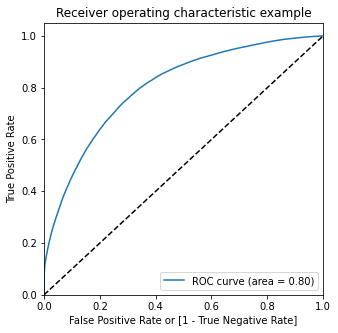

In [772]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)

In [773]:
### Optimal Cut off Point Check

In [774]:
# create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Conversion_Prob,ID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.087868,L29UAVJD,1,0,0,0,0,0,0,0,0,0
1,0,0.015115,NMRKVXVD,1,0,0,0,0,0,0,0,0,0
2,0,0.084063,QJWQ3P6U,1,0,0,0,0,0,0,0,0,0
3,1,0.298011,MNXHWV8Y,1,1,1,0,0,0,0,0,0,0
4,0,0.369010,JEMGWPXT,1,1,1,1,0,0,0,0,0,0


In [775]:
# create a dataframe to see the values of accuracy, sensitivity, and specificity at different values of probability cutoffs

cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.237641  1.000000  0.000000
0.1   0.1  0.552007  0.914204  0.439103
0.2   0.2  0.672769  0.821313  0.626465
0.3   0.3  0.754929  0.661782  0.783964
0.4   0.4  0.794194  0.460808  0.898117
0.5   0.5  0.800526  0.290513  0.959506
0.6   0.6  0.793107  0.162173  0.989781
0.7   0.7  0.786474  0.108646  0.997766
0.8   0.8  0.782724  0.087949  0.999298
0.9   0.9  0.780067  0.075105  0.999817


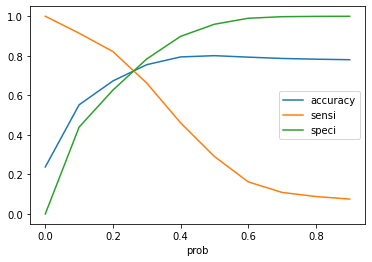

In [776]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [777]:
#### From the curve above, approx value of 0.25 is the optimum point to take it as a cutoff probability.

y_train_pred_final['final_Predicted'] = y_train_pred_final.Conversion_Prob.map( lambda x: 1 if x > 0.25 else 0)
y_train_pred_final.head()

,Converted,Conversion_Prob,ID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_Predicted
0,1,0.087868,L29UAVJD,1,0,0,0,0,0,0,0,0,0,0
1,0,0.015115,NMRKVXVD,1,0,0,0,0,0,0,0,0,0,0
2,0,0.084063,QJWQ3P6U,1,0,0,0,0,0,0,0,0,0,0
3,1,0.298011,MNXHWV8Y,1,1,1,0,0,0,0,0,0,0,1
4,0,0.369010,JEMGWPXT,1,1,1,1,0,0,0,0,0,0,1


In [778]:
### Apply Optimal CutOff on Test Set and Download for Submission.

leads_df_test.head()
#### From the curve above, approx value of 0.25 is the optimum point to take it as a cutoff probability.

leads_df_test['final_Predicted'] = leads_df_test.pred.map( lambda x: 1 if x > 0.25 else 0)
leads_df_test.head()
leads_df_test['ID'] = leads_df_test.index
leads_df_test[['ID','final_Predicted']].to_csv('final_predicted.csv')
files.download('final_predicted.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [779]:
### Some checks below on Final Training Prediction.

In [780]:
## Adding Lead Core Column : Lead Score = 100 * ConversionProbability
y_train_pred_final['Lead_Score'] = y_train_pred_final.Conversion_Prob.map( lambda x: round(x*100))

# Display Data
y_train_pred_final[['Converted','Conversion_Prob','ID','final_Predicted','Lead_Score']].head()

,Converted,Conversion_Prob,ID,final_Predicted,Lead_Score
0,1,0.087868,L29UAVJD,0,9
1,0,0.015115,NMRKVXVD,0,2
2,0,0.084063,QJWQ3P6U,0,8
3,1,0.298011,MNXHWV8Y,1,30
4,0,0.369010,JEMGWPXT,1,37


In [781]:
y_train_pred_final[['ID','final_Predicted']]

,ID,final_Predicted
0,L29UAVJD,0
1,NMRKVXVD,0
2,QJWQ3P6U,0
3,MNXHWV8Y,1
4,JEMGWPXT,1
...,...,...
172002,8MTUAWG5,1
172003,EVDBF6ZP,0
172004,GGSFWQMN,0
172005,NLJCS9WK,1


In [782]:
# Let's check the overall accuracy.
accuracy_score= metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_Predicted)
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_Predicted )
precision_score = precision_score(y_train_pred_final.Converted , y_train_pred_final.final_Predicted)
recall_score = recall_score(y_train_pred_final.Converted, y_train_pred_final.final_Predicted)

print("Accuracy Score:" + str(accuracy_score))
print("Precision Score:" + str(precision_score))
print("Recall Score:" + str(recall_score))
print("Confusion matrix:" + str(confusion2))



Accuracy Score:0.7169359386536595
Precision Score:0.44364297358512345
Recall Score:0.7523241021626382
Confusion matrix:[[92566 38565]
 [10124 30752]]


In [783]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives
sensitivity = TP / float(TP+FN)
specificity = TN / float(TN+FP)
positivePredictedValue = TP / float(TP+FP)
negativePredictedValue = TN / float(TN+ FN)
precision =confusion2[1,1]/(confusion2[0,1]+confusion2[1,1])
recall = confusion2[1,1]/(confusion2[1,0]+confusion2[1,1])
print("Sensitivity:" + str(sensitivity))
print("Specificity:" + str(specificity))
print ("Positive Predicted Value: " + str(positivePredictedValue))
print ("Negative predictive value: " + str(negativePredictedValue))
print("Precision:" + str(precision))
print("Recall:" + str(recall))


Sensitivity:0.7523241021626382
Specificity:0.7059047822406601
Positive Predicted Value: 0.44364297358512345
Negative predictive value: 0.90141201674944
Precision:0.44364297358512345
Recall:0.7523241021626382
